1. Title: Pima Indians Diabetes Database

2. Sources:
   (a) Original owners: National Institute of Diabetes and Digestive and
                        Kidney Diseases
   (b) Donor of database: Vincent Sigillito (vgs@aplcen.apl.jhu.edu)
                          Research Center, RMI Group Leader
                          Applied Physics Laboratory
                          The Johns Hopkins University
                          Johns Hopkins Road
                          Laurel, MD 20707
                          (301) 953-6231
   (c) Date received: 9 May 1990

3. Past Usage:
    1. Smith,~J.~W., Everhart,~J.~E., Dickson,~W.~C., Knowler,~W.~C., \&
       Johannes,~R.~S. (1988). Using the ADAP learning algorithm to forecast
       the onset of diabetes mellitus.  In {\it Proceedings of the Symposium
       on Computer Applications and Medical Care} (pp. 261--265).  IEEE
       Computer Society Press.

       The diagnostic, binary-valued variable investigated is whether the
       patient shows signs of diabetes according to World Health Organization
       criteria (i.e., if the 2 hour post-load plasma glucose was at least
       200 mg/dl at any survey  examination or if found during routine medical
       care).   The population lives near Phoenix, Arizona, USA.

       Results: Their ADAP algorithm makes a real-valued prediction between
       0 and 1.  This was transformed into a binary decision using a cutoff of
       0.448.  Using 576 training instances, the sensitivity and specificity
       of their algorithm was 76% on the remaining 192 instances.

4. Relevant Information:
      Several constraints were placed on the selection of these instances from
      a larger database.  In particular, all patients here are females at
      least 21 years old of Pima Indian heritage.  ADAP is an adaptive learning
      routine that generates and executes digital analogs of perceptron-like
      devices.  It is a unique algorithm; see the paper for details.

5. Number of Instances: 768

6. Number of Attributes: 8 plus class

7. For Each Attribute: (all numeric-valued)
   1. Number of times pregnant
   2. Plasma glucose concentration a 2 hours in an oral glucose tolerance test
   3. Diastolic blood pressure (mm Hg)
   4. Triceps skin fold thickness (mm)
   5. 2-Hour serum insulin (mu U/ml)
   6. Body mass index (weight in kg/(height in m)^2)
   7. Diabetes pedigree function
   8. Age (years)
   9. Class variable (0 or 1)

8. Missing Attribute Values: Yes

9. Class Distribution: (class value 1 is interpreted as "tested positive for
   diabetes")

   Class Value  Number of instances
   0            500
   1            268

10. Brief statistical analysis:

| Attribute number | Mean | Standard Deviation  |
|-------------------|------|---------------------|
| 1.                | 3.8  | 3.4                 |
| 2.                | 120.9| 32.0                |
| 3.                | 69.1 | 19.4                |
| 4.                | 20.5 | 16.0                |
| 5.                | 79.8 | 115.2               |
| 6.                | 32.0 | 7.9                 |
| 7.                | 0.5  | 0.3                 |
| 8.                | 33.2 | 11.8                |




In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from pathlib import Path

%matplotlib inline

In [2]:

class Value:
    """ stores a single scalar value and its gradient """

    def __init__(self, data, _children=(), _op=''):
        self.data = data
        self.grad = 0
        # internal variables used for autograd graph construction
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op # the op that produced this node, for graphviz / debugging / etc
        self.m = np.zeros_like(data)
        self.v = np.zeros_like(data)

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward

        return out

    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward

        return out

    def backward(self):

        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()

    def __neg__(self): # -self
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1

    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"

In [3]:
class Module:

    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0

    def parameters(self):
        return []

class Neuron(Module):

    def __init__(self, nin, nonlin=True):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(0)
        self.nonlin = nonlin

    def __call__(self, x):
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
        return act.relu() if self.nonlin else act

    def parameters(self):
        return self.w + [self.b]

    def __repr__(self):
        return f"{'ReLU' if self.nonlin else 'Linear'}Neuron({len(self.w)})"

class Layer(Module):

    def __init__(self, nin, nout, **kwargs):
        self.neurons = [Neuron(nin, **kwargs) for _ in range(nout)]

    def __call__(self, x):
        out = [n(x) for n in self.neurons]
        return out[0] if len(out) == 1 else out

    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]

    def __repr__(self):
        return f"Layer of [{', '.join(str(n) for n in self.neurons)}]"

class MLP(Module):

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1], nonlin=i!=len(nouts)-1) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

    def __repr__(self):
        return f"MLP of [{', '.join(str(layer) for layer in self.layers)}]"

In [4]:
# Ensure that we have a `data` directory we use to store downloaded data
!mkdir -p data
data_dir: Path = Path('data')

# Downloading the "Pinma India Diabetes" data set
!wget -nc -P data https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.csv

# Load data and process it
df = pd.read_csv('data/pima-indians-diabetes.csv')
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values


# Normalize X inputs data
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# assign labels to y
y = y*2 - 1 # make y be -1 or 1

zsh:1: command not found: wget


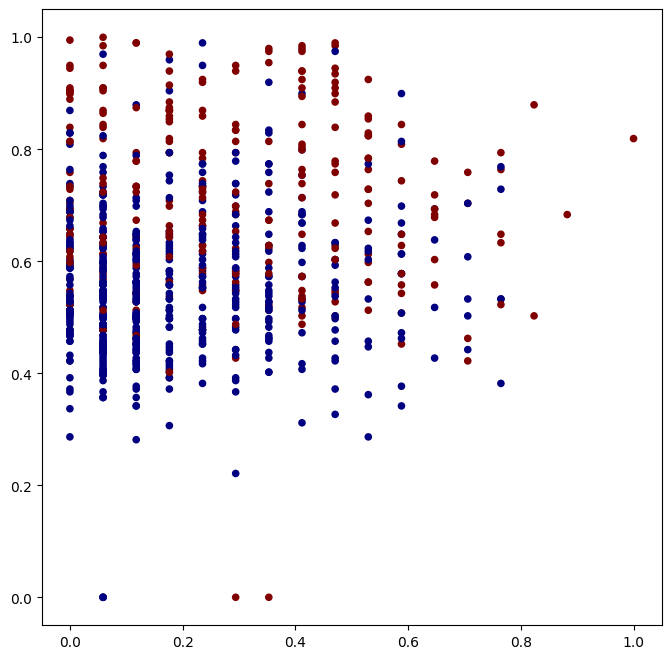

In [5]:
# visualize in 2D
plt.figure(figsize=(8,8))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')
# print(y_label)

In [6]:
np.random.seed(42)
random.seed(42)

# initialize a model
model = MLP(8, [16, 16,  1]) # 2-layer neural network
print(model)
print("number of parameters", len(model.parameters()))

MLP of [Layer of [ReLUNeuron(8), ReLUNeuron(8), ReLUNeuron(8), ReLUNeuron(8), ReLUNeuron(8), ReLUNeuron(8), ReLUNeuron(8), ReLUNeuron(8), ReLUNeuron(8), ReLUNeuron(8), ReLUNeuron(8), ReLUNeuron(8), ReLUNeuron(8), ReLUNeuron(8), ReLUNeuron(8), ReLUNeuron(8)], Layer of [ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16)], Layer of [LinearNeuron(16)]]
number of parameters 433


In [7]:
# loss function
def loss(batch_size=None):

    # inline DataLoader :)
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    inputs = [list(map(Value, xrow)) for xrow in Xb]

    # forward the model to get scores
    scores = list(map(model, inputs))

    # svm "max-margin" loss
    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in model.parameters()))
    total_loss = data_loss + reg_loss

    # also get accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

total_loss, acc = loss()
print(total_loss, acc)

Value(data=0.9454812010081969, grad=0) 0.6440677966101694


In [8]:
# optimization
for k in range(100):

    # forward
    total_loss, acc = loss()

    # backward
    model.zero_grad()
    total_loss.backward()

    # update (sgd)
    learning_rate = 1.0 - 0.95*k/100
    for p in model.parameters():
        p.data -= learning_rate * p.grad

    if k % 10 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")

step 0 loss 0.9454812010081969, accuracy 64.40677966101694%
step 10 loss 0.6969129698080643, accuracy 65.31942633637549%
step 20 loss 0.6728932986795271, accuracy 67.40547588005215%
step 30 loss 0.7033091438865514, accuracy 67.79661016949152%
step 40 loss 0.5974924031938655, accuracy 74.44589308996089%
step 50 loss 0.5758899211571545, accuracy 75.7496740547588%
step 60 loss 0.5570071104626843, accuracy 76.27118644067797%
step 70 loss 0.5278095462483867, accuracy 77.18383311603651%
step 80 loss 0.5199443951928561, accuracy 77.44458930899609%
step 90 loss 0.5153881597194936, accuracy 77.70534550195566%
